Branin synthetic function:

GP ERM versus GP dERM (winner)

https://www.sfu.ca/~ssurjano/branin.html

In [1]:
pip install pyGPGO


In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'Branin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'ERM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Branin':

    # True y bounds:
    y_lb = 0.397887
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -5
    ub_x1 = +10
    lb_x2 = +0
    ub_x2 = +15

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) +
                 s * (1 - t) * np.cos(x1_training) + s)


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 66
run_num_7 = 7
run_num_8 = 88
run_num_9 = 9
run_num_10 = 10
run_num_11 = 111
run_num_12 = 12
run_num_13 = 13
run_num_14 = 144
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]

    def ERM(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        f = (std + self.eps) * (norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        #df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df2 = (std + self.eps) * (-gamma * norm.pdf(gamma))
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 1.25533007 10.8048674 ]	 56.52874005	 27.6816669	     	     	     	     	    
init	 [-4.99828438  4.53498859]	 172.66531087	 27.6816669	     	     	     	     	    
init	 [-2.79866164  1.38507892]	 102.58290349	 27.6816669	     	     	     	     	    
init	 [-2.20609683  5.18341091]	 28.8680646	 27.6816669	     	     	     	     	    
init	 [0.95151211 8.08225101]	 27.6816669	 27.6816669	     	     	     	     	    
1  	 [-4.22145238  7.77482174]	 57.97731376	 27.6816669	 28.4 	 0.79788243 	 0.79788101 	 1.0 	 3.137
2	 [-1.72421857 10.06552573]	 9.41110782	 9.41110782	 19.4 	 0.79787875 	 0.79787406 	 1.0 	 6.643
3  	 [0.293941   1.78918465]	 33.2839562	 9.41110782	 32.1 	 0.7978672 	 0.79787862 	 1.0 	 5.331
4  	 [3.89041289 9.39114213]	 61.14800575	 9.41110782	 18.0 	 0.797865 	 0.79786848 	 1.0 	 2.977
5  	 [ 3.68788563 12.66291284]	 117.90446901	 9.41110782	 49.2 	 0.7978

In [15]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.53992353 0.38889348]	 22.31361309	 6.69205151	     	     	     	     	    
init	 [3.24493717 6.52983589]	 19.23310997	 6.69205151	     	     	     	     	    
init	 [1.30551703 4.95502232]	 13.17785156	 6.69205151	     	     	     	     	    
init	 [-1.93027049  9.2890645 ]	 6.69205151	 6.69205151	     	     	     	     	    
init	 [-0.50517989  4.00240913]	 26.43752276	 6.69205151	     	     	     	     	    
1	 [3.02490859 2.64117891]	 0.53794051	 0.53794051	 35.8 	 0.79776657 	 0.79779064 	 1.0 	 5.011
2  	 [-1.22091056  1.25066856]	 60.69523779	 0.53794051	 44.7 	 0.79777569 	 0.7978303 	 1.0 	 10.318
3  	 [-3.63040739  3.03317285]	 110.67125536	 0.53794051	 47.7 	 0.79776191 	 0.79786989 	 1.0 	 6.808
4  	 [-3.71698267  6.1825696 ]	 58.4643436	 0.53794051	 30.2 	 0.79780584 	 0.7978794 	 1.0 	 6.428
5  	 [-5.         8.8428388]	 82.35478831	 0.53794051	 35.2 	 0.7977111

In [16]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.26196854 10.62221734]	 71.68783452	 18.07886746	     	     	     	     	    
init	 [-0.63642892  7.66241408]	 18.07886746	 18.07886746	     	     	     	     	    
init	 [ 8.39420432 13.44439633]	 141.9865353	 18.07886746	     	     	     	     	    
init	 [-3.11622034  3.10864317]	 83.31045707	 18.07886746	     	     	     	     	    
init	 [-4.22799195  6.61214765]	 76.52941707	 18.07886746	     	     	     	     	    
1  	 [ 9.07299063 14.68990665]	 157.12744507	 18.07886746	 11.1 	 0.79788144 	 0.79788144 	 1.0 	 2.104
2  	 [ 5.1520949  13.57035601]	 166.38975583	 18.07886746	 26.4 	 0.79787578 	 0.79788138 	 1.0 	 3.389
3  	 [ 7.42182066 10.3959313 ]	 96.68980973	 18.07886746	 30.3 	 0.79787589 	 0.79788087 	 1.0 	 3.65
4  	 [9.3377092  7.96243079]	 31.34670216	 18.07886746	 21.4 	 0.79787584 	 0.79787777 	 1.0 	 11.577
5  	 [-4.14880531  9.63530228]	 31.82023265	 18.0

In [17]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [9.50544759 8.20848374]	 32.51676745	 7.24712687	     	     	     	     	    
init	 [ 9.5902654  10.72223991]	 66.20566674	 7.24712687	     	     	     	     	    
init	 [5.46593237 3.24134243]	 20.90089402	 7.24712687	     	     	     	     	    
init	 [9.64411682 0.09345383]	 7.24712687	 7.24712687	     	     	     	     	    
init	 [-1.20526456  6.52187299]	 15.94137698	 7.24712687	     	     	     	     	    
1  	 [4.80988882 5.71609749]	 30.14177972	 7.24712687	 23.4 	 0.79774027 	 0.79774131 	 1.0 	 4.471
2  	 [ 6.80669373 11.76139032]	 130.87382243	 7.24712687	 18.6 	 0.79782261 	 0.79786994 	 1.0 	 3.969
3  	 [ 8.6903186 14.3686304]	 157.7134815	 7.24712687	 34.0 	 0.79788127 	 0.7978813 	 1.0 	 4.907
4  	 [4.21843274 9.88939926]	 74.41028426	 7.24712687	 33.0 	 0.79784561 	 0.79788088 	 1.0 	 4.035
5  	 [ 2.17317076 12.10088774]	 84.65299607	 7.24712687	 37.8 	 0.79765

In [18]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.67010243 13.06098459]	 25.39069055	 25.31130919	     	     	     	     	    
init	 [-1.89921267 13.77916362]	 25.31130919	 25.31130919	     	     	     	     	    
init	 [2.32616783 9.17615794]	 41.60147975	 25.31130919	     	     	     	     	    
init	 [6.48861785 7.77626982]	 63.81281922	 25.31130919	     	     	     	     	    
init	 [-0.54799248  2.81581843]	 34.96620364	 25.31130919	     	     	     	     	    
1  	 [ 8.42943747 10.01316459]	 72.83310176	 25.31130919	 27.4 	 0.79786026 	 0.79786908 	 1.0 	 5.7
2	 [3.7185686  6.35664066]	 22.09979993	 22.09979993	 36.2 	 0.79787254 	 0.79787332 	 1.0 	 3.948
3	 [10.          7.38756152]	 21.16790088	 21.16790088	 34.5 	 0.78277449 	 0.79787563 	 0.981 	 5.18
4  	 [ 5.41577293 10.95450237]	 111.95520918	 21.16790088	 36.9 	 0.79787251 	 0.79787833 	 1.0 	 5.051
5  	 [ 4.54297998 13.97526226]	 165.61872581	 21.16790088	 

In [19]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68568633  2.00549341]	 86.03160634	 20.52092754	     	     	     	     	    
init	 [ 0.44028199 10.18663313]	 42.32854406	 20.52092754	     	     	     	     	    
init	 [-2.08324914  3.76815575]	 42.60068433	 20.52092754	     	     	     	     	    
init	 [6.37624587 8.36427884]	 72.27103718	 20.52092754	     	     	     	     	    
init	 [2.72204377 7.01699793]	 20.52092754	 20.52092754	     	     	     	     	    
1  	 [0.44177447 1.75380437]	 31.41303527	 20.52092754	 22.2 	 0.79787724 	 0.79787698 	 1.0 	 3.592
2  	 [ 3.76454113 10.10369786]	 70.50147539	 20.52092754	 28.8 	 0.79784752 	 0.79787527 	 1.0 	 3.823
3  	 [ 7.00519933 11.37693569]	 120.9731565	 20.52092754	 33.6 	 0.79787714 	 0.79787636 	 1.0 	 4.428
4  	 [10.         10.32308352]	 55.52739874	 20.52092754	 37.5 	 0.79788023 	 0.79788039 	 1.0 	 4.244
5  	 [ 8.40379423 14.223384  ]	 160.6068226	 20.5209275

In [20]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.85537566 11.69878188]	 8.29931785	 5.21133532	     	     	     	     	    
init	 [ 1.57613847 10.85197767]	 59.50408381	 5.21133532	     	     	     	     	    
init	 [9.66984268 8.07743806]	 29.71492141	 5.21133532	     	     	     	     	    
init	 [2.51680695 1.080767  ]	 5.21133532	 5.21133532	     	     	     	     	    
init	 [-0.9734153   7.49823751]	 15.4310572	 5.21133532	     	     	     	     	    
1  	 [0.03870518 8.83915193]	 28.00816717	 5.21133532	 18.0 	 0.79765636 	 0.79765956 	 1.0 	 2.914
2  	 [3.56236568 8.66116808]	 46.01081158	 5.21133532	 31.8 	 0.79786643 	 0.79786837 	 1.0 	 4.598
3  	 [ 4.56278129 11.66214338]	 113.31474553	 5.21133532	 24.2 	 0.79787154 	 0.79787322 	 1.0 	 6.583
4  	 [ 6.2516742  14.31891368]	 194.36015217	 5.21133532	 28.0 	 0.79787962 	 0.79787962 	 1.0 	 4.749
5  	 [ 2.24533372 14.04383848]	 124.25873219	 5.21133532	 35.0 	 0.

In [21]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.71326574 7.60724532]	 48.93133297	 16.42817527	     	     	     	     	    
init	 [ 2.9251207  13.44427806]	 121.49896937	 16.42817527	     	     	     	     	    
init	 [ 5.49986786 10.71445653]	 108.19981146	 16.42817527	     	     	     	     	    
init	 [5.76007573 3.34229193]	 23.26238481	 16.42817527	     	     	     	     	    
init	 [-2.37268215  6.85262233]	 16.42817527	 16.42817527	     	     	     	     	    
1  	 [ 6.13812002 14.1402977 ]	 189.60015179	 16.42817527	 27.8 	 0.79788089 	 0.79788203 	 1.0 	 4.487
2  	 [ 9.44331461 14.27682728]	 139.31279421	 16.42817527	 35.4 	 0.79788281 	 0.79788281 	 1.0 	 3.834
3  	 [ 0.1191126 14.9193288]	 102.4727923	 16.42817527	 26.8 	 0.79787949 	 0.79788027 	 1.0 	 5.214
4  	 [2.26160414 9.94887229]	 51.32050078	 16.42817527	 39.4 	 0.79787957 	 0.7978817 	 1.0 	 8.652
5  	 [ 8.60528757 10.21425876]	 73.06399821	 16.428175

In [22]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.84438769  7.52811888]	 96.15564307	 3.46402486	     	     	     	     	    
init	 [2.4365994  2.00744293]	 3.46402486	 3.46402486	     	     	     	     	    
init	 [-2.86833372  3.27838013]	 70.46930174	 3.46402486	     	     	     	     	    
init	 [1.27762271 3.72151753]	 12.98282592	 3.46402486	     	     	     	     	    
init	 [-3.73910523  5.1824796 ]	 75.58547401	 3.46402486	     	     	     	     	    
1  	 [-1.7046801   7.98301364]	 9.94033554	 3.46402486	 24.2 	 0.79787859 	 0.79787976 	 1.0 	 3.881
2  	 [-0.98330863  0.96117681]	 60.59779089	 3.46402486	 32.0 	 0.79752941 	 0.79787069 	 1.0 	 6.501
3  	 [-4.15411776 10.55010297]	 23.32348335	 3.46402486	 26.7 	 0.79786847 	 0.79787754 	 1.0 	 5.622
4  	 [-4.06221097  0.29109504]	 208.84520695	 3.46402486	 35.8 	 0.79777859 	 0.79787655 	 1.0 	 7.267
5  	 [-1.52668598 10.94359894]	 15.31947124	 3.46402486	 30.4 	

In [23]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.56980965 0.31127924]	 19.86398502	 2.71061096	     	     	     	     	    
init	 [ 4.50472352 11.23205824]	 103.66999147	 2.71061096	     	     	     	     	    
init	 [2.47760518 3.37194968]	 2.71061096	 2.71061096	     	     	     	     	    
init	 [-2.02905703 11.40796068]	 8.46393084	 2.71061096	     	     	     	     	    
init	 [-2.46333745  1.32509721]	 90.49481266	 2.71061096	     	     	     	     	    
1  	 [ 2.43981262 12.13229587]	 88.16252944	 2.71061096	 20.7 	 0.79787687 	 0.7978787 	 1.0 	 2.604
2  	 [3.31139633 8.34019361]	 38.90028039	 2.71061096	 45.8 	 0.7978783 	 0.79787897 	 1.0 	 5.287
3  	 [6.83739988 9.14016352]	 81.89059068	 2.71061096	 35.4 	 0.79787837 	 0.79787893 	 1.0 	 4.544
4  	 [ 7.68130825 12.27343297]	 129.94601417	 2.71061096	 51.3 	 0.79788048 	 0.79788052 	 1.0 	 5.599
5  	 [ 6.00008723 15.        ]	 212.39258757	 2.71061096	 36.2 	 0.7

In [24]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.18255263 2.53604632]	 6.01740403	 6.01740403	     	     	     	     	    
init	 [ 1.54088529 11.53893709]	 69.34033362	 6.01740403	     	     	     	     	    
init	 [-0.57012043  2.23744436]	 40.28559663	 6.01740403	     	     	     	     	    
init	 [-4.66282513  6.30336738]	 108.05910203	 6.01740403	     	     	     	     	    
init	 [-1.41976788  5.06484288]	 23.38302591	 6.01740403	     	     	     	     	    
1  	 [-2.34875713  8.44707678]	 7.27599329	 6.01740403	 43.5 	 0.79787919 	 0.79787937 	 1.0 	 8.283
2  	 [-1.42451865 11.94842559]	 23.08971774	 6.01740403	 21.9 	 0.79787145 	 0.79787157 	 1.0 	 3.394
3  	 [ 1.09655657 14.5099623 ]	 116.39189513	 6.01740403	 25.0 	 0.79787154 	 0.79787233 	 1.0 	 11.494
4  	 [ 4.24053949 13.88554843]	 157.20997353	 6.01740403	 48.4 	 0.79787353 	 0.79788087 	 1.0 	 5.365
5  	 [ 6.73679246 11.80317705]	 132.31267218	 6.01740403	 

In [25]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68755736 11.10074545]	 1.38277028	 0.54993153	     	     	     	     	    
init	 [-1.05027477  8.0060909 ]	 14.81231853	 0.54993153	     	     	     	     	    
init	 [-4.78137556 13.78120512]	 18.401131	 0.54993153	     	     	     	     	    
init	 [8.51072281 0.50132141]	 5.85517236	 0.54993153	     	     	     	     	    
init	 [9.35424004 2.05813982]	 0.54993153	 0.54993153	     	     	     	     	    
1  	 [-3.47819893  7.93193221]	 27.63102488	 0.54993153	 27.4 	 0.7975986 	 0.79760407 	 1.0 	 5.425
2  	 [-2.05327529  5.46063289]	 24.48379367	 0.54993153	 21.2 	 0.79757149 	 0.79780105 	 1.0 	 3.8
3  	 [-4.90978687  5.39377207]	 144.9282828	 0.54993153	 42.0 	 0.7975705 	 0.79783604 	 1.0 	 6.24
4  	 [0.65176553 5.67451171]	 18.06539995	 0.54993153	 23.8 	 0.79756034 	 0.79779774 	 1.0 	 5.287
5  	 [-3.80451313  2.34719142]	 136.47563043	 0.54993153	 24.8 	 0.7976034

In [26]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.66553616 3.5631183 ]	 24.8236702	 18.03894306	     	     	     	     	    
init	 [ 7.36417799 14.48623797]	 188.78033347	 18.03894306	     	     	     	     	    
init	 [9.58901671 6.80173871]	 18.03894306	 18.03894306	     	     	     	     	    
init	 [ 4.13563694 11.63289772]	 104.87319704	 18.03894306	     	     	     	     	    
init	 [ 4.62420017 10.83027344]	 98.03271226	 18.03894306	     	     	     	     	    
1  	 [3.14177498 8.15951834]	 35.02711692	 18.03894306	 14.0 	 0.78318097 	 0.79787545 	 0.982 	 2.906
2  	 [6.40084871 8.27545331]	 70.94346518	 18.03894306	 24.8 	 0.7978739 	 0.79787499 	 1.0 	 3.76
3  	 [ 8.25143299 11.14371419]	 96.16513323	 18.03894306	 18.9 	 0.79778207 	 0.79788289 	 1.0 	 4.29
4  	 [ 1.0603137  11.80695553]	 68.70319284	 18.03894306	 11.7 	 0.79501351 	 0.79787669 	 0.996 	 2.394
5  	 [-1.73559414 12.85075562]	 22.10979511	 18.0389430

In [27]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.59983913 13.3641452 ]	 1.39008244	 1.39008244	     	     	     	     	    
init	 [2.15101746 2.6028287 ]	 5.06258176	 1.39008244	     	     	     	     	    
init	 [5.66659793 7.61961773]	 59.95574639	 1.39008244	     	     	     	     	    
init	 [ 1.88565728 12.11064259]	 81.89070663	 1.39008244	     	     	     	     	    
init	 [5.19935765 4.42757614]	 24.79948444	 1.39008244	     	     	     	     	    
1  	 [ 4.81199793 10.67311172]	 98.19673544	 1.39008244	 33.9 	 0.79778512 	 0.79787787 	 1.0 	 4.378
2  	 [1.95484517 8.87809019]	 36.60452545	 1.39008244	 34.4 	 0.79787802 	 0.79788055 	 1.0 	 4.74
3  	 [ 6.55007955 13.24283235]	 166.28103804	 1.39008244	 42.6 	 0.79787799 	 0.79787798 	 1.0 	 10.108
4  	 [ 9.79396524 12.84658227]	 101.89782441	 1.39008244	 36.0 	 0.79788228 	 0.79788228 	 1.0 	 5.473
5  	 [-1.00076934 11.09100709]	 26.53097519	 1.39008244	 35.4 	 0.

In [28]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [7.73226546 2.68343887]	 12.76872453	 12.76872453	     	     	     	     	    
init	 [-4.18455179  5.42307669]	 95.39334177	 12.76872453	     	     	     	     	    
init	 [-0.86898607  7.95000337]	 16.41948778	 12.76872453	     	     	     	     	    
init	 [-0.41121626  4.56711539]	 23.25036274	 12.76872453	     	     	     	     	    
init	 [-3.32388086  3.74848521]	 80.99796278	 12.76872453	     	     	     	     	    
1  	 [-4.97413486  8.39367198]	 88.50907324	 12.76872453	 34.4 	 0.79787666 	 0.79787665 	 1.0 	 8.142
2  	 [-4.8698147  11.46031887]	 40.16914541	 12.76872453	 26.8 	 0.79787645 	 0.79787645 	 1.0 	 4.263
3  	 [-1.19410718  1.52126426]	 56.61055284	 12.76872453	 26.4 	 0.79784589 	 0.79787184 	 1.0 	 3.623
4	 [1.71349532 2.20581791]	 10.72640209	 10.72640209	 36.9 	 0.79786605 	 0.79786717 	 1.0 	 7.754
5	 [-2.13712027 12.06785802]	 9.16001037	 9.16001037	 1

In [29]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.65063381  7.84745012]	 10.51470213	 2.71586401	     	     	     	     	    
init	 [3.26052185 0.68402925]	 2.71586401	 2.71586401	     	     	     	     	    
init	 [0.41093253 3.34621413]	 22.88951513	 2.71586401	     	     	     	     	    
init	 [5.33089243 2.45597138]	 17.17815761	 2.71586401	     	     	     	     	    
init	 [-3.945127  14.1151629]	 3.36492243	 2.71586401	     	     	     	     	    
1  	 [3.09870848 4.14760967]	 3.78837334	 2.71586401	 41.6 	 0.79779861 	 0.79780666 	 1.0 	 5.49
2  	 [0.62182799 6.02870142]	 18.74257748	 2.71586401	 30.4 	 0.79767711 	 0.79778575 	 1.0 	 6.724
3  	 [-2.00481745  4.79932827]	 30.07675794	 2.71586401	 35.4 	 0.79767858 	 0.79781967 	 1.0 	 11.175
4  	 [-2.19625789  1.95442073]	 71.03174582	 2.71586401	 25.4 	 0.7976768 	 0.79783933 	 1.0 	 4.987
5  	 [-5.          3.10265896]	 211.10255639	 2.71586401	 33.3 	 0.7976990

In [30]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.58002496  7.95880133]	 19.01614112	 19.01614112	     	     	     	     	    
init	 [-2.1271882   1.01850537]	 85.05949339	 19.01614112	     	     	     	     	    
init	 [6.8047819  9.84500283]	 93.89792695	 19.01614112	     	     	     	     	    
init	 [4.56281344 8.63404341]	 60.50217141	 19.01614112	     	     	     	     	    
init	 [-4.41405626  5.36720407]	 110.70834087	 19.01614112	     	     	     	     	    
1  	 [ 4.11858371 11.76404774]	 107.19683439	 19.01614112	 22.2 	 0.79787748 	 0.79787829 	 1.0 	 3.909
2  	 [ 7.20462155 13.10318242]	 156.56467577	 19.01614112	 32.4 	 0.79788111 	 0.79788128 	 1.0 	 4.272
3  	 [ 9.865639  14.9681575]	 147.63341717	 19.01614112	 27.2 	 0.79788199 	 0.79788199 	 1.0 	 6.118
4  	 [ 9.9046578 10.8169223]	 64.00916815	 19.01614112	 17.4 	 0.79787953 	 0.79788161 	 1.0 	 2.815
5  	 [ 4.10554246 14.99249898]	 182.7254088	 19.01614

In [31]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.75561363 7.58180061]	 49.21505906	 8.15007522	     	     	     	     	    
init	 [8.17902206 2.72760338]	 8.15007522	 8.15007522	     	     	     	     	    
init	 [ 7.78349603 11.25204429]	 106.98107857	 8.15007522	     	     	     	     	    
init	 [ 4.99152501 14.81843172]	 196.08601751	 8.15007522	     	     	     	     	    
init	 [-1.14547366  0.42458888]	 71.23649636	 8.15007522	     	     	     	     	    
1  	 [ 8.58867561 14.41801267]	 161.26583974	 8.15007522	 29.8 	 0.79788197 	 0.79788206 	 1.0 	 3.463
2  	 [ 2.21676342 12.99805433]	 102.05811804	 8.15007522	 29.4 	 0.79785912 	 0.79788293 	 1.0 	 7.431
3  	 [8.92901579 8.33675982]	 40.59385767	 8.15007522	 30.8 	 0.79787214 	 0.7978791 	 1.0 	 4.51
4  	 [-0.67229231 14.16180071]	 66.98173494	 8.15007522	 22.0 	 0.79787214 	 0.79787847 	 1.0 	 3.19
5  	 [-0.05633053 10.76036629]	 41.39861751	 8.15007522	 23.0 	 

In [32]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.53699597 11.41874575]	 4.47560827	 4.47560827	     	     	     	     	    
init	 [-1.2959304   2.07197531]	 51.13947794	 4.47560827	     	     	     	     	    
init	 [-0.02830155  1.24499348]	 42.63973922	 4.47560827	     	     	     	     	    
init	 [ 5.07965622 12.09890697]	 131.17235665	 4.47560827	     	     	     	     	    
init	 [9.74112872 9.53491102]	 46.84458914	 4.47560827	     	     	     	     	    
1  	 [ 8.02859812 13.33741732]	 147.29590581	 4.47560827	 20.2 	 0.79788107 	 0.79788098 	 1.0 	 3.13
2  	 [ 3.73939508 15.        ]	 174.85509353	 4.47560827	 23.6 	 0.79785465 	 0.79788092 	 1.0 	 7.133
3  	 [3.46111065 9.34647365]	 54.28291033	 4.47560827	 26.1 	 0.79786523 	 0.79788085 	 1.0 	 6.94
4  	 [0.5800247  4.36333229]	 18.60471412	 4.47560827	 24.0 	 0.79786812 	 0.79786703 	 1.0 	 6.459
5  	 [ 0.77222604 13.59031984]	 93.3066996	 4.47560827	 35.0 	 0

In [33]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.82196202 13.46570592]	 138.52643499	 14.0426674	     	     	     	     	    
init	 [ 8.37296094 12.23756216]	 115.63178541	 14.0426674	     	     	     	     	    
init	 [-4.46165622 10.37636373]	 35.66708529	 14.0426674	     	     	     	     	    
init	 [0.68021413 7.77766418]	 25.30776991	 14.0426674	     	     	     	     	    
init	 [4.86927198 2.90775327]	 14.0426674	 14.0426674	     	     	     	     	    
1  	 [ 1.14125677 11.68779168]	 67.81424527	 14.0426674	 28.5 	 0.79785281 	 0.79788136 	 1.0 	 3.528
2  	 [8.36742522 9.08189339]	 59.37032495	 14.0426674	 28.8 	 0.7975706 	 0.79787985 	 1.0 	 10.051
3  	 [ 5.42689078 10.20266666]	 97.92653966	 14.0426674	 15.8 	 0.79784867 	 0.79787914 	 1.0 	 2.483
4  	 [3.98701187 7.40719009]	 36.11027682	 14.0426674	 20.4 	 0.79783598 	 0.79787796 	 1.0 	 4.973
5  	 [ 0.30137543 14.61650737]	 101.69616555	 14.0426674	 39.6 	 

In [34]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 1.25533007 10.8048674 ]	 56.52874005	 27.6816669	     	     	     	     	    
init	 [-4.99828438  4.53498859]	 172.66531087	 27.6816669	     	     	     	     	    
init	 [-2.79866164  1.38507892]	 102.58290349	 27.6816669	     	     	     	     	    
init	 [-2.20609683  5.18341091]	 28.8680646	 27.6816669	     	     	     	     	    
init	 [0.95151211 8.08225101]	 27.6816669	 27.6816669	     	     	     	     	    
1  	 [-4.64306919  7.81298254]	 79.25232559	 27.6816669	 16.4 	 0.79788243 	 0.79788101 	 1.0 	 3.24
2  	 [0.07365165 2.69368034]	 29.75090597	 27.6816669	 17.3 	 0.79787875 	 0.79787443 	 1.0 	 2.893
3  	 [ 4.16989339 10.96965865]	 92.6520543	 27.6816669	 17.8 	 0.79786472 	 0.7978685 	 1.0 	 4.321
4  	 [ 3.41568166 13.97442678]	 142.44897469	 27.6816669	 16.6 	 0.79787777 	 0.79787755 	 1.0 	 10.301
5  	 [ 6.64288413 14.13921686]	 188.27510463	 27.6816669	 19.8 

In [35]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.53992353 0.38889348]	 22.31361309	 6.69205151	     	     	     	     	    
init	 [3.24493717 6.52983589]	 19.23310997	 6.69205151	     	     	     	     	    
init	 [1.30551703 4.95502232]	 13.17785156	 6.69205151	     	     	     	     	    
init	 [-1.93027049  9.2890645 ]	 6.69205151	 6.69205151	     	     	     	     	    
init	 [-0.50517989  4.00240913]	 26.43752276	 6.69205151	     	     	     	     	    
1	 [3.4329236  2.16733989]	 0.81428497	 0.81428497	 29.3 	 0.79776657 	 0.79779064 	 1.0 	 4.686
2  	 [-1.42671437  6.60505104]	 15.0981775	 0.81428497	 25.5 	 0.79777569 	 0.79783028 	 1.0 	 5.448
3  	 [0.53570644 8.34449196]	 28.24267286	 0.81428497	 25.9 	 0.79768743 	 0.7978129 	 1.0 	 12.579
4  	 [3.92207185 8.99512757]	 55.74090062	 0.81428497	 21.1 	 0.7977391 	 0.79782423 	 1.0 	 15.022
5  	 [ 3.71802817 11.90137533]	 102.61034826	 0.81428497	 23.8 	 0.79786401

In [36]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.26196854 10.62221734]	 71.68783452	 18.07886746	     	     	     	     	    
init	 [-0.63642892  7.66241408]	 18.07886746	 18.07886746	     	     	     	     	    
init	 [ 8.39420432 13.44439633]	 141.9865353	 18.07886746	     	     	     	     	    
init	 [-3.11622034  3.10864317]	 83.31045707	 18.07886746	     	     	     	     	    
init	 [-4.22799195  6.61214765]	 76.52941707	 18.07886746	     	     	     	     	    
1  	 [ 9.08761883 14.68179541]	 156.60183176	 18.07886746	 20.3 	 0.79788144 	 0.79788144 	 1.0 	 0.5
2  	 [-0.27534829  4.28471956]	 23.92029582	 18.07886746	 14.2 	 0.79787578 	 0.79788137 	 1.0 	 12.099
3	 [-3.13644072  9.50091103]	 8.02506274	 8.02506274	 17.6 	 0.79787083 	 0.79788006 	 1.0 	 1.797
4  	 [1.88607881 5.8744605 ]	 12.86297209	 8.02506274	 19.6 	 0.79780303 	 0.797881 	 1.0 	 8.312
5  	 [4.12388681 6.61944627]	 29.52838659	 8.02506274	 15.

In [37]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [9.50544759 8.20848374]	 32.51676745	 7.24712687	     	     	     	     	    
init	 [ 9.5902654  10.72223991]	 66.20566674	 7.24712687	     	     	     	     	    
init	 [5.46593237 3.24134243]	 20.90089402	 7.24712687	     	     	     	     	    
init	 [9.64411682 0.09345383]	 7.24712687	 7.24712687	     	     	     	     	    
init	 [-1.20526456  6.52187299]	 15.94137698	 7.24712687	     	     	     	     	    
1  	 [4.32167479 5.5280982 ]	 22.29104518	 7.24712687	 24.8 	 0.79774027 	 0.79774131 	 1.0 	 2.917
2  	 [5.53931458 7.80686006]	 61.40875434	 7.24712687	 20.5 	 0.7977578 	 0.79786994 	 1.0 	 1.788
3  	 [7.56971809 4.88755918]	 25.17349313	 7.24712687	 27.4 	 0.79780346 	 0.79787224 	 1.0 	 10.944
4  	 [ 9.21778968 13.66926688]	 129.72814451	 7.24712687	 15.4 	 0.79786988 	 0.79786988 	 1.0 	 12.827
5  	 [1.13830428 7.30308562]	 22.71153336	 7.24712687	 24.0 	 0.79765

In [38]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.67010243 13.06098459]	 25.39069055	 25.31130919	     	     	     	     	    
init	 [-1.89921267 13.77916362]	 25.31130919	 25.31130919	     	     	     	     	    
init	 [2.32616783 9.17615794]	 41.60147975	 25.31130919	     	     	     	     	    
init	 [6.48861785 7.77626982]	 63.81281922	 25.31130919	     	     	     	     	    
init	 [-0.54799248  2.81581843]	 34.96620364	 25.31130919	     	     	     	     	    
1  	 [ 4.7334492  10.77256234]	 98.78102185	 25.31130919	 20.5 	 0.79786026 	 0.79786908 	 1.0 	 3.711
2  	 [ 7.44577753 12.28327415]	 134.18897673	 25.31130919	 20.8 	 0.79787808 	 0.79787909 	 1.0 	 3.421
3  	 [ 3.88304672 13.78930914]	 147.43548788	 25.31130919	 13.9 	 0.79787915 	 0.79788165 	 1.0 	 4.205
4	 [-0.48608571  5.5665552 ]	 20.02153171	 20.02153171	 15.7 	 0.79783315 	 0.79786912 	 1.0 	 2.744
5  	 [9.39420914 8.36637003]	 35.41367375	 20.0215317

In [39]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68568633  2.00549341]	 86.03160634	 20.52092754	     	     	     	     	    
init	 [ 0.44028199 10.18663313]	 42.32854406	 20.52092754	     	     	     	     	    
init	 [-2.08324914  3.76815575]	 42.60068433	 20.52092754	     	     	     	     	    
init	 [6.37624587 8.36427884]	 72.27103718	 20.52092754	     	     	     	     	    
init	 [2.72204377 7.01699793]	 20.52092754	 20.52092754	     	     	     	     	    
1  	 [0.40552902 1.60175079]	 33.06696125	 20.52092754	 12.1 	 0.79787724 	 0.79787698 	 1.0 	 25.684
2  	 [-5.  0.]	 308.12909601	 20.52092754	 15.5 	 0.79784729 	 0.79787552 	 1.0 	 19.82
3  	 [ 6.81546926 11.33501021]	 121.93590676	 20.52092754	 22.0 	 0.79787249 	 0.79787249 	 1.0 	 6.217
4  	 [ 9.97147448 11.64883714]	 77.03703586	 20.52092754	 15.2 	 0.79788031 	 0.79788048 	 1.0 	 3.114
5  	 [ 8.72481006 14.47299658]	 159.53482608	 20.52092754	 13.2 	 0.

In [40]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.85537566 11.69878188]	 8.29931785	 5.21133532	     	     	     	     	    
init	 [ 1.57613847 10.85197767]	 59.50408381	 5.21133532	     	     	     	     	    
init	 [9.66984268 8.07743806]	 29.71492141	 5.21133532	     	     	     	     	    
init	 [2.51680695 1.080767  ]	 5.21133532	 5.21133532	     	     	     	     	    
init	 [-0.9734153   7.49823751]	 15.4310572	 5.21133532	     	     	     	     	    
1  	 [-0.01040129  8.86905854]	 27.73829469	 5.21133532	 22.4 	 0.79765636 	 0.79765956 	 1.0 	 2.402
2  	 [ 4.46185496 11.38645765]	 105.9444214	 5.21133532	 22.1 	 0.79786644 	 0.79786813 	 1.0 	 7.862
3  	 [ 6.90186658 13.34145575]	 165.98755603	 5.21133532	 17.6 	 0.79787891 	 0.79787891 	 1.0 	 2.076
4  	 [ 9.90356966 14.63218791]	 138.92282407	 5.21133532	 21.7 	 0.79788227 	 0.79788227 	 1.0 	 6.605
5  	 [ 2.38921322 13.95573187]	 124.44905187	 5.21133532	 19.2 

In [41]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.71326574 7.60724532]	 48.93133297	 16.42817527	     	     	     	     	    
init	 [ 2.9251207  13.44427806]	 121.49896937	 16.42817527	     	     	     	     	    
init	 [ 5.49986786 10.71445653]	 108.19981146	 16.42817527	     	     	     	     	    
init	 [5.76007573 3.34229193]	 23.26238481	 16.42817527	     	     	     	     	    
init	 [-2.37268215  6.85262233]	 16.42817527	 16.42817527	     	     	     	     	    
1  	 [ 5.9196671  14.56102384]	 200.02575208	 16.42817527	 18.6 	 0.79788089 	 0.79788203 	 1.0 	 1.068
2  	 [ 9.24377122 14.54184295]	 149.76815137	 16.42817527	 22.6 	 0.79788299 	 0.79788299 	 1.0 	 5.909
3  	 [8.24326697 9.17622357]	 62.86877769	 16.42817527	 14.6 	 0.7978795 	 0.79788025 	 1.0 	 4.478
4	 [2.2733272  6.09158615]	 13.04977852	 13.04977852	 19.3 	 0.79785651 	 0.79788168 	 1.0 	 3.597
5  	 [5.92486284 0.63232675]	 19.2158395	 13.04977852	 1

In [42]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.84438769  7.52811888]	 96.15564307	 3.46402486	     	     	     	     	    
init	 [2.4365994  2.00744293]	 3.46402486	 3.46402486	     	     	     	     	    
init	 [-2.86833372  3.27838013]	 70.46930174	 3.46402486	     	     	     	     	    
init	 [1.27762271 3.72151753]	 12.98282592	 3.46402486	     	     	     	     	    
init	 [-3.73910523  5.1824796 ]	 75.58547401	 3.46402486	     	     	     	     	    
1  	 [-1.85444364  8.41728317]	 8.27005967	 3.46402486	 18.0 	 0.79787859 	 0.79787976 	 1.0 	 2.689
2  	 [3.45271873 4.69857508]	 7.90103838	 3.46402486	 24.9 	 0.79752942 	 0.79787069 	 1.0 	 19.146
3  	 [-3.47730221 10.4472749 ]	 7.95150552	 3.46402486	 25.0 	 0.79776538 	 0.7978776 	 1.0 	 5.561
4  	 [-0.51630904  5.91654987]	 19.23333423	 3.46402486	 21.3 	 0.79781809 	 0.7978707 	 1.0 	 6.355
5  	 [1.73487918 7.1764918 ]	 21.02562377	 3.46402486	 27.7 	 0.79774

In [43]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.56980965 0.31127924]	 19.86398502	 2.71061096	     	     	     	     	    
init	 [ 4.50472352 11.23205824]	 103.66999147	 2.71061096	     	     	     	     	    
init	 [2.47760518 3.37194968]	 2.71061096	 2.71061096	     	     	     	     	    
init	 [-2.02905703 11.40796068]	 8.46393084	 2.71061096	     	     	     	     	    
init	 [-2.46333745  1.32509721]	 90.49481266	 2.71061096	     	     	     	     	    
1  	 [-0.31413051  1.88513407]	 40.5466212	 2.71061096	 22.3 	 0.79787687 	 0.7978787 	 1.0 	 12.022
2  	 [ 7.59776575 11.64757113]	 118.16278306	 2.71061096	 18.9 	 0.7978787 	 0.7978787 	 1.0 	 5.528
3  	 [7.00103126 8.47689531]	 70.33985746	 2.71061096	 25.3 	 0.79782813 	 0.79788201 	 1.0 	 2.437
4  	 [-2.4451295   4.45810188]	 41.14592883	 2.71061096	 18.8 	 0.79787794 	 0.79787865 	 1.0 	 4.323
5  	 [ 7.76444507 14.80440528]	 189.71732281	 2.71061096	 20.0 	 0.

In [44]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.18255263 2.53604632]	 6.01740403	 6.01740403	     	     	     	     	    
init	 [ 1.54088529 11.53893709]	 69.34033362	 6.01740403	     	     	     	     	    
init	 [-0.57012043  2.23744436]	 40.28559663	 6.01740403	     	     	     	     	    
init	 [-4.66282513  6.30336738]	 108.05910203	 6.01740403	     	     	     	     	    
init	 [-1.41976788  5.06484288]	 23.38302591	 6.01740403	     	     	     	     	    
1  	 [-3.1253244   9.03528012]	 10.64336677	 6.01740403	 18.6 	 0.79787919 	 0.79787937 	 1.0 	 4.021
2  	 [ 4.06112721 13.14644056]	 135.95400821	 6.01740403	 20.2 	 0.79787145 	 0.79787151 	 1.0 	 3.329
3  	 [-1.53390107 10.99431114]	 15.41255141	 6.01740403	 21.8 	 0.79713706 	 0.79788114 	 0.999 	 6.639
4  	 [ 6.89945955 14.63632847]	 199.2132371	 6.01740403	 17.4 	 0.79788114 	 0.79788114 	 1.0 	 4.936
5  	 [2.00388092 3.71508518]	 6.11895559	 6.01740403	 23.

In [45]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.68755736 11.10074545]	 1.38277028	 0.54993153	     	     	     	     	    
init	 [-1.05027477  8.0060909 ]	 14.81231853	 0.54993153	     	     	     	     	    
init	 [-4.78137556 13.78120512]	 18.401131	 0.54993153	     	     	     	     	    
init	 [8.51072281 0.50132141]	 5.85517236	 0.54993153	     	     	     	     	    
init	 [9.35424004 2.05813982]	 0.54993153	 0.54993153	     	     	     	     	    
1  	 [1.35377453 7.7305488 ]	 25.37830329	 0.54993153	 22.0 	 0.7975986 	 0.79760407 	 1.0 	 1.91
2  	 [ 1.8769822  10.31114739]	 53.9368885	 0.54993153	 21.4 	 0.79778728 	 0.79781008 	 1.0 	 2.772
3  	 [ 4.1124003  12.16110015]	 115.27905497	 0.54993153	 20.6 	 0.79786257 	 0.79786303 	 1.0 	 4.217
4  	 [ 6.42502193 14.30519319]	 193.6949913	 0.54993153	 20.6 	 0.79787979 	 0.79787991 	 1.0 	 3.617
5  	 [ 9.73436688 14.48867327]	 138.68542761	 0.54993153	 21.8 	 0.7978

In [46]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [6.66553616 3.5631183 ]	 24.8236702	 18.03894306	     	     	     	     	    
init	 [ 7.36417799 14.48623797]	 188.78033347	 18.03894306	     	     	     	     	    
init	 [9.58901671 6.80173871]	 18.03894306	 18.03894306	     	     	     	     	    
init	 [ 4.13563694 11.63289772]	 104.87319704	 18.03894306	     	     	     	     	    
init	 [ 4.62420017 10.83027344]	 98.03271226	 18.03894306	     	     	     	     	    
1	 [8.10720165 0.13073598]	 9.7176693	 9.7176693	 17.8 	 0.78318097 	 0.79787545 	 0.982 	 0.0
2  	 [7.50891675 9.88163086]	 86.32527776	 9.7176693	 19.8 	 0.79787394 	 0.79787424 	 1.0 	 3.302
3	 [9.69668848 1.76906558]	 1.64341111	 1.64341111	 19.0 	 0.79731939 	 0.79787644 	 0.999 	 1.714
4  	 [ 9.93185095 12.10581805]	 85.69273038	 1.64341111	 17.6 	 0.7978821 	 0.7978807 	 1.0 	 3.515
5  	 [10.          3.56647501]	 2.26069365	 1.64341111	 16.6 	 0.790886

In [47]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.59983913 13.3641452 ]	 1.39008244	 1.39008244	     	     	     	     	    
init	 [2.15101746 2.6028287 ]	 5.06258176	 1.39008244	     	     	     	     	    
init	 [5.66659793 7.61961773]	 59.95574639	 1.39008244	     	     	     	     	    
init	 [ 1.88565728 12.11064259]	 81.89070663	 1.39008244	     	     	     	     	    
init	 [5.19935765 4.42757614]	 24.79948444	 1.39008244	     	     	     	     	    
1  	 [7.81818995 4.1979384 ]	 17.87691501	 1.39008244	 18.6 	 0.79778512 	 0.79787787 	 1.0 	 7.981
2  	 [ 6.60529394 10.4056818 ]	 105.26427079	 1.39008244	 17.0 	 0.79786699 	 0.79787551 	 1.0 	 0.182
3  	 [ 6.82413867 13.52258403]	 171.18768545	 1.39008244	 15.3 	 0.79787884 	 0.7978801 	 1.0 	 14.944
4  	 [ 3.42960863 14.85569544]	 164.49496602	 1.39008244	 18.2 	 0.7978795 	 0.79788254 	 1.0 	 2.177
5  	 [ 9.91523519 14.60975055]	 138.18507449	 1.39008244	 20.1 	 0

In [48]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [7.73226546 2.68343887]	 12.76872453	 12.76872453	     	     	     	     	    
init	 [-4.18455179  5.42307669]	 95.39334177	 12.76872453	     	     	     	     	    
init	 [-0.86898607  7.95000337]	 16.41948778	 12.76872453	     	     	     	     	    
init	 [-0.41121626  4.56711539]	 23.25036274	 12.76872453	     	     	     	     	    
init	 [-3.32388086  3.74848521]	 80.99796278	 12.76872453	     	     	     	     	    
1  	 [-4.9154184   8.40889812]	 84.79097114	 12.76872453	 18.8 	 0.79787666 	 0.79787665 	 1.0 	 3.885
2  	 [-4.98561948 11.46239834]	 44.89350772	 12.76872453	 23.8 	 0.79787571 	 0.79787571 	 1.0 	 6.712
3	 [-2.14632964 11.64220752]	 7.43422605	 7.43422605	 22.6 	 0.79785409 	 0.79787355 	 1.0 	 7.614
4	 [-4.14263241 14.18875313]	 5.20654622	 5.20654622	 28.3 	 0.7978529 	 0.79785349 	 1.0 	 4.902
5  	 [1.59160542 6.42510521]	 16.72222053	 5.20654622	 21.0 

In [49]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.65063381  7.84745012]	 10.51470213	 2.71586401	     	     	     	     	    
init	 [3.26052185 0.68402925]	 2.71586401	 2.71586401	     	     	     	     	    
init	 [0.41093253 3.34621413]	 22.88951513	 2.71586401	     	     	     	     	    
init	 [5.33089243 2.45597138]	 17.17815761	 2.71586401	     	     	     	     	    
init	 [-3.945127  14.1151629]	 3.36492243	 2.71586401	     	     	     	     	    
1  	 [2.89565792 4.33567081]	 4.15036784	 2.71586401	 25.4 	 0.79779861 	 0.79780666 	 1.0 	 6.87
2  	 [6.32322072 4.73701145]	 32.81149695	 2.71586401	 20.1 	 0.79767677 	 0.79777458 	 1.0 	 4.162
3  	 [8.13692795 2.4632526 ]	 8.05937737	 2.71586401	 23.0 	 0.79782638 	 0.79782936 	 1.0 	 6.564
4  	 [8.30616676 6.60437421]	 29.92538736	 2.71586401	 24.0 	 0.79782469 	 0.79782537 	 1.0 	 4.61
5  	 [4.42394796 6.74397873]	 34.90044366	 2.71586401	 18.7 	 0.79780385 	 0.797

In [50]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.58002496  7.95880133]	 19.01614112	 19.01614112	     	     	     	     	    
init	 [-2.1271882   1.01850537]	 85.05949339	 19.01614112	     	     	     	     	    
init	 [6.8047819  9.84500283]	 93.89792695	 19.01614112	     	     	     	     	    
init	 [4.56281344 8.63404341]	 60.50217141	 19.01614112	     	     	     	     	    
init	 [-4.41405626  5.36720407]	 110.70834087	 19.01614112	     	     	     	     	    
1  	 [ 5.4696926 12.6320864]	 148.21434176	 19.01614112	 13.5 	 0.79787748 	 0.79787829 	 1.0 	 15.188
2  	 [-1.24218597  4.13551885]	 29.42706981	 19.01614112	 18.6 	 0.79788086 	 0.79788169 	 1.0 	 15.073
3  	 [ 8.4443098  13.90364261]	 151.82845516	 19.01614112	 19.0 	 0.79788173 	 0.7978817 	 1.0 	 13.011
4  	 [-4.39876169  8.51334359]	 55.85731527	 19.01614112	 20.6 	 0.79787953 	 0.79788237 	 1.0 	 15.877
5	 [-1.73568082 10.38244541]	 9.93890135	 9.93890

In [51]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.75561363 7.58180061]	 49.21505906	 8.15007522	     	     	     	     	    
init	 [8.17902206 2.72760338]	 8.15007522	 8.15007522	     	     	     	     	    
init	 [ 7.78349603 11.25204429]	 106.98107857	 8.15007522	     	     	     	     	    
init	 [ 4.99152501 14.81843172]	 196.08601751	 8.15007522	     	     	     	     	    
init	 [-1.14547366  0.42458888]	 71.23649636	 8.15007522	     	     	     	     	    
1  	 [ 8.59956152 14.40795514]	 160.76439201	 8.15007522	 18.9 	 0.79788197 	 0.79788206 	 1.0 	 2.337
2  	 [7.09916342 5.89746082]	 38.53261199	 8.15007522	 19.4 	 0.79785912 	 0.79788293 	 1.0 	 2.3
3  	 [-0.49377525  3.35114081]	 30.46984695	 8.15007522	 10.9 	 0.79787214 	 0.79787986 	 1.0 	 3.056
4	 [2.00345496 2.21022011]	 7.22771338	 7.22771338	 20.0 	 0.79783129 	 0.79788293 	 1.0 	 3.153
5  	 [9.08173231 8.10323656]	 35.79568823	 7.22771338	 18.8 	 0.79786

In [52]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.53699597 11.41874575]	 4.47560827	 4.47560827	     	     	     	     	    
init	 [-1.2959304   2.07197531]	 51.13947794	 4.47560827	     	     	     	     	    
init	 [-0.02830155  1.24499348]	 42.63973922	 4.47560827	     	     	     	     	    
init	 [ 5.07965622 12.09890697]	 131.17235665	 4.47560827	     	     	     	     	    
init	 [9.74112872 9.53491102]	 46.84458914	 4.47560827	     	     	     	     	    
1  	 [ 8.11321982 13.12729712]	 140.62714733	 4.47560827	 21.0 	 0.79788107 	 0.79788098 	 1.0 	 4.285
2  	 [-1.49261405  4.91660855]	 24.78823765	 4.47560827	 21.2 	 0.79785465 	 0.7978809 	 1.0 	 3.269
3  	 [1.49456355 3.79051319]	 10.74553782	 4.47560827	 15.8 	 0.79786507 	 0.79788088 	 1.0 	 2.869
4  	 [2.63255467 0.48169509]	 6.56039905	 4.47560827	 27.8 	 0.79783614 	 0.79788088 	 1.0 	 11.764
5  	 [3.77155343 3.66856677]	 5.60302461	 4.47560827	 21.4 	 0.7

In [53]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.82196202 13.46570592]	 138.52643499	 14.0426674	     	     	     	     	    
init	 [ 8.37296094 12.23756216]	 115.63178541	 14.0426674	     	     	     	     	    
init	 [-4.46165622 10.37636373]	 35.66708529	 14.0426674	     	     	     	     	    
init	 [0.68021413 7.77766418]	 25.30776991	 14.0426674	     	     	     	     	    
init	 [4.86927198 2.90775327]	 14.0426674	 14.0426674	     	     	     	     	    
1  	 [ 1.12965148 11.68031857]	 67.58510774	 14.0426674	 17.5 	 0.79785281 	 0.79788136 	 1.0 	 3.711
2  	 [6.60439553 4.57213036]	 31.00368779	 14.0426674	 21.9 	 0.7975706 	 0.79787985 	 1.0 	 4.342
3  	 [3.19009931 9.23668622]	 49.39813091	 14.0426674	 14.6 	 0.79785912 	 0.79788238 	 1.0 	 3.952
4	 [-2.99320012 12.7154763 ]	 1.13425453	 1.13425453	 14.0 	 0.79783601 	 0.79787985 	 1.0 	 7.46
5  	 [ 9.95423416 14.96841139]	 145.96687161	 1.13425453	 18.4 	 0.797

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-2.0200415467087427, -0.6802817724719147)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-1.9657306953252849, -0.8761138152661507)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(1.051956818065038, -0.19274887102787303)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(0.6601868330181386, 0.6533664979857557)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(1.8330991104317371, 1.3746543830166553)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(1.2479947578664106, 0.3020229188689683)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(1.5714137345790247, -0.28124602626130507)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(0.5290368934935333, -1.6085846562421933)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(1.120418743036621, -0.9846141876265988)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-0.09647540265015304, 0.12558502701629148)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(1.7262457218821414, 0.023521446717251995)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(-1.8835818529313322, -1.8835818529313322)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(0.7269239300827792, 0.21955641308261656)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-0.007835170045524763, -0.007835170045524763)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(2.072197885909781, 0.49485044962802477)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.8406948255363631, 0.8406948255363631)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(2.5936936885165993, 0.5972761626489905)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-1.9273673335285615, 1.5117383478005315)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(0.7172927076986543, 1.117309806883974)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(1.9629688236095835, -0.5329980040085871)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-27.68166689936483,
 0.7978824318432791,
 0.7978810142612474,
 16.4,
 3.240012035049444,
 -27.68166689936483,
 0.7978787549933394,
 0.7978744259297061,
 17.3,
 2.8929854887081747,
 -27.68166689936483,
 0.7978647178579905,
 0.7978685013502769,
 17.8,
 4.32056794199523,
 -27.68166689936483,
 0.7978777699335883,
 0.797877551968014,
 16.6,
 10.300831038170806,
 -27.68166689936483,
 0.7978816571229498,
 0.7978821981203591,
 19.8,
 15.876324982524665,
 -27.68166689936483,
 0.7978827866778471,
 0.7978827866746331,
 17.6,
 17.257459135389016,
 -27.68166689936483,
 0.7978114661318747,
 0.79788182342459,
 17.2,
 3.872333928984078,
 -1.6847969665494045,
 0.7978749482823001,
 0.7978792636299002,
 20.6,
 4.819858727684124,
 -1.6847969665494045,
 0.7945885634189916,
 0.7978816099112777,
 19.4,
 1.7455308270402954,
 -1.6847969665494045,
 0.7961193063755265,
 0.7978823229187831,
 21.1,
 2.940708140780927,
 -1.6847969665494045,
 0.7830395434847658,
 0.7978802379174268,
 16.8,
 7.474810665739943,
 -1.6

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([27.6816669 , 27.6816669 , 27.6816669 , 27.6816669 , 27.6816669 ,
       27.6816669 ,  1.68479697,  1.68479697,  1.68479697,  1.68479697,
        1.68479697,  1.68479697,  1.68479697,  1.68479697,  1.68479697,
        1.68479697,  1.20792674,  1.17254903,  0.90436126,  0.90436126])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.7977665743249929,
 0.7977906405205123,
 0.8142849708774058,
 0.5379405127712538)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(0.7978320979566533,
 0.7978793105301454,
 1.2225760514502788,
 3.2611354961337344)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(0.7977844458461066, 0.7977913416711607, 2.3198873602552066, 2.333040851263931)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(0.797835438892614, 0.7978550954207393, 4.351597017426624, 6.651123129284953)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.7977264670915621, 0.7978802762644495, 1.7504792262382445, 3.881237987342292)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(0.7928276439833328, 0.7978271452068713, 1.152729601530302, 5.211335324193094)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.7977867836500161, 0.7978803917007294, 0.5980577240637057, 2.095183843548017)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(0.7968262578900375,
 0.7978768618408381,
 0.7714703322081373,
 3.4640248583909496)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(0.7978002068632778, 0.797859347778736, 1.5316985694769336, 1.3059192325115543)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.7974611314763418, 0.7978739838979156, 1.421687257665825, 6.017404026582318)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.7975985984767228,
 0.7976040675208649,
 0.5499315281120278,
 0.5499315281120278)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(0.7973193899474293,
 0.7978764378650409,
 1.6434111098283672,
 2.4665943220026563)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.7977851194431844,
 0.7978778718288734,
 1.3900824448893765,
 1.3900824448893765)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(0.7975017682231222, 0.797873527650381, 2.0381399202793826, 8.340147130180153)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(0.7977986115496192, 0.7978066563230608, 2.715864006988424, 2.715864006988424)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(0.7978456025228331, 0.7978804571716973, 2.215049398424844, 13.77698567082489)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(0.7916928269346307, 0.7978624681862062, 4.932493670356733, 0.543417828727069)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(0.7976453718383432, 0.7978816596264853, 3.4545072340632137, 2.446765781553207)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(0.7977325359328258, 0.7978660227352542, 0.9847299721773108, 7.518322032371886)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(17.8, 12.8)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(35.8, 29.3)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(19.6, 16.0)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(37.4, 14.6)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(35.2, 21.4)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(27.4, 18.2)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(18.0, 18.2)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(22.6, 14.8)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(24.2, 13.8)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(15.3, 15.8)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(43.5, 12.6)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(27.4, 22.0)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(17.8, 19.0)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(33.9, 18.6)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(25.4, 19.2)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(41.6, 25.4)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(31.6, 14.2)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(21.9, 12.4)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(15.3, 21.0)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(23.1, 17.6)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(6.334187346287506, 4.868755603360612)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(9.118224375317153, 5.576167838876028)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(5.3020407202329105, 6.736838209689241)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(6.978821158791516, 3.657231046817384)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(6.926278358284262, 4.706904782049523)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(6.590215160226218, 5.9397474439064935)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(7.359547795391005, 3.495506469200271)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(7.226265500933662, 4.113518980331014)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(6.618660671630761, 8.01660439145601)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(6.224464698130381, 7.21699364063044)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(7.055881271429909, 5.610248993278399)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(6.900345665874764, 3.4065942004950167)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(6.561811583256642, 2.6537463847570497)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(8.464180567448107, 4.5058269896368905)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(7.37691122733506, 8.181027238737986)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(8.193469997680129, 4.373979882759331)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(6.85342082591517, 8.484733727663977)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(7.478437624369116, 3.385102696299196)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(6.790572105325732, 6.787972290906512)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(6.651853246113672, 3.6176052457581647)

In [157]:
### Summarise arrays: 'GP ERM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dERM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP ERM maximum (when compared to GP dERM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dERM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP ERM, resultant tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dERM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP ERM, average nfev at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(26.74, 17.845)

In [162]:
### Summarise arrays: 'GP ERM, average Euclid at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(7.050279494998682, 5.266755302830477)

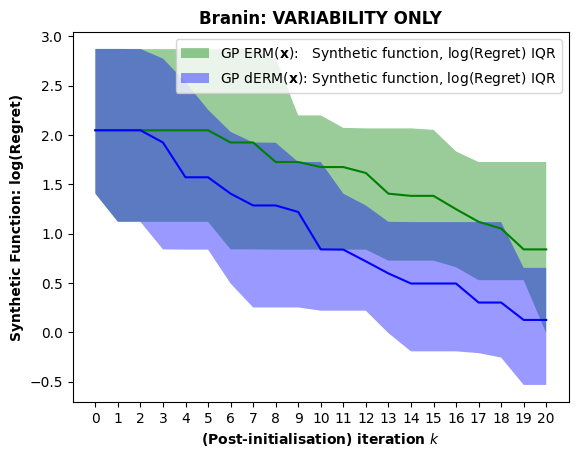

In [163]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP dERM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


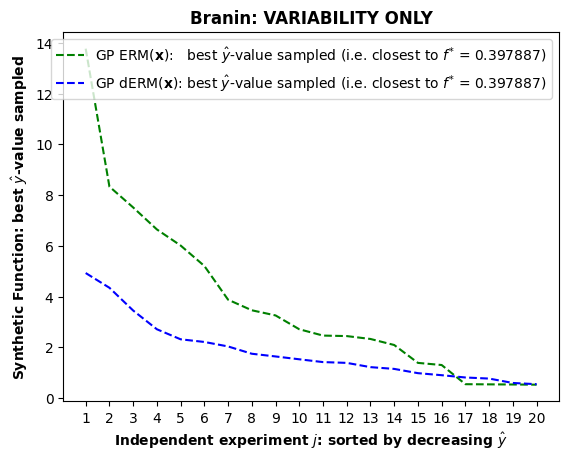

In [164]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Green', ls='--', label='GP ERM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0.397887)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Blue', ls='--', label='GP dERM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0.397887)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


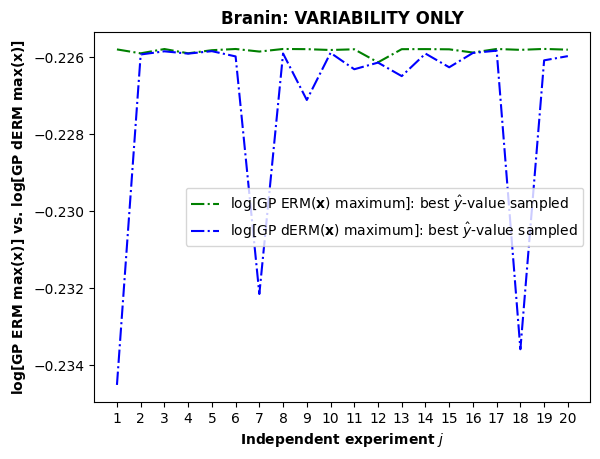

In [165]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Green', ls='-.', label='log[GP ERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Blue', ls='-.', label='log[GP dERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP ERM max($\mathbf{x}$)] vs. log[GP dERM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


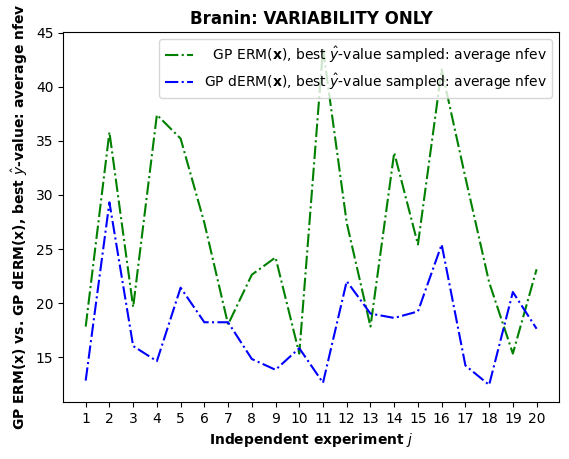

In [166]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


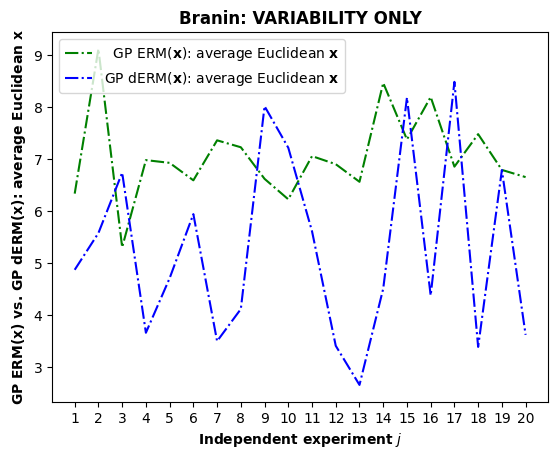

In [167]:
### Visualise!

erm_stddev = ': VARIABILITY ONLY'
title = obj_func + erm_stddev

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0.0469, 0.7979, 0.    , 0.    , 0.    , 0.    , 0.    , 0.7977,
        0.7979, 0.    , 0.    , 0.7898, 0.0469, 0.7979, 0.    , 0.2844,
        0.7619, 0.7819, 0.7979, 0.4355]),
 0.7979,
 array([-2.62553557,  1.33492609]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([2.360e-02, 5.267e-01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.500e-03, 4.031e-01, 0.000e+00, 0.000e+00, 3.121e-01,
        2.350e-02, 3.679e-01, 0.000e+00, 1.000e-04, 7.739e-01, 2.000e-04,
        3.000e-04, 3.510e-02]),
 0.7739,
 array([9.99236944, 4.61965238]))

In [170]:
np.round(approx_4.x_best, 4)


array([[ 0.489 ,  6.5965],
       [-4.9891,  2.0574],
       [ 3.337 , 10.1564],
       [ 4.6679, 14.2133],
       [ 0.4346, 12.9307],
       [ 6.2632, 10.4714],
       [ 7.6566, 13.3655],
       [ 0.9825,  1.7404],
       [-4.9162,  6.5526],
       [ 3.3253, 14.5406],
       [ 3.4857, 12.1579],
       [ 2.263 ,  0.    ],
       [ 0.489 ,  6.5965],
       [-4.9287,  6.5415],
       [ 3.8146, 11.9597],
       [ 5.948 , 15.    ],
       [10.    ,  2.4952],
       [10.    ,  4.2082],
       [-2.6255,  1.3349],
       [-1.4503,  8.6651]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[ 0.4817,  7.0746],
       [-4.7806,  2.78  ],
       [ 3.337 , 10.1564],
       [ 4.6679, 14.2133],
       [ 0.4346, 12.9307],
       [ 6.2632, 10.4714],
       [ 7.6566, 13.3655],
       [ 5.4561,  0.9362],
       [-2.1528,  8.4503],
       [ 3.3253, 14.5406],
       [ 3.4857, 12.1579],
       [ 4.4671,  1.3629],
       [ 0.3843,  7.1172],
       [-2.7897,  6.9884],
       [ 3.8146, 11.9597],
       [ 4.8758, 12.7596],
       [ 9.9924,  4.6197],
       [ 9.3031,  6.815 ],
       [ 4.4069,  4.2628],
       [-0.3852,  7.6198]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


11.127345542153531

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

4.259558937428112